# Accumulators

Accumulators are a special kind of variable that we basically use to update some data points across executors. One thing we really need to remember is that the operation by which the data point update happens has to be an associated and commutative operation. 

Accumulators are variables that are only “added” to through an associative and commutative operation and can therefore be efficiently supported in parallel. They can be used to implement counters (as in MapReduce) or sums. Spark natively supports accumulators of numeric types, and programmers can add support for new types.

As a user, you can create named or unnamed accumulators. As seen in the image below, a named accumulator (in this instance counter) will display in the web UI for the stage that modifies that accumulator. Spark displays the value for each accumulator modified by a task in the “Tasks” table.

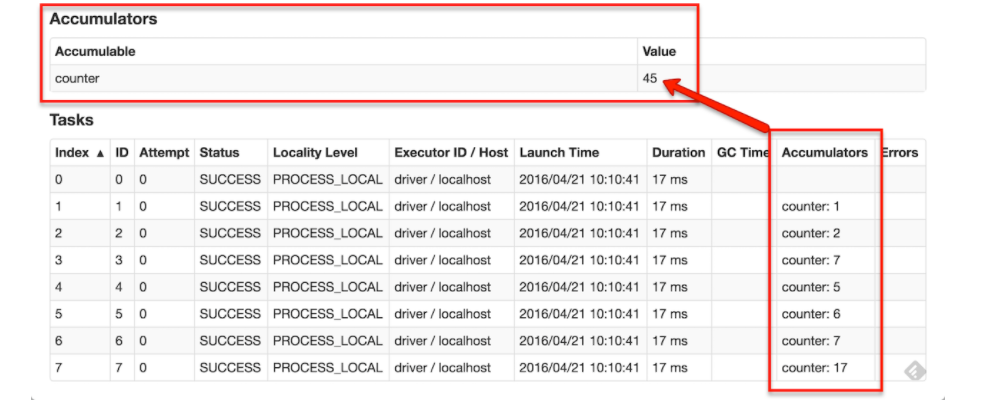

An accumulator is created from an initial value v by calling SparkContext.accumulator(v). Tasks running on a cluster can then add to it using the add method or the += operator. However, they cannot read its value. Only the driver program can read the accumulator’s value, using its value method.

The code below shows an accumulator being used to add up the elements of an array:

In [2]:
! pip install pyspark
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("accumulator").getOrCreate()

accum=spark.sparkContext.accumulator(0)
rdd=spark.sparkContext.parallelize([1,2,3,4,5])
rdd.foreach(lambda x:accum.add(x))
print('Sum',accum.value)

accuSum=spark.sparkContext.accumulator(0)
def countFun(x):
    global accuSum
    accuSum+=x
rdd.foreach(countFun)
print('Sum',accuSum.value)

accumCount=spark.sparkContext.accumulator(0)
rdd2=spark.sparkContext.parallelize([1,2,3,4,5])
rdd2.foreach(lambda x:accumCount.add(1))
print('Count',accumCount.value)

Defaulting to user installation because normal site-packages is not writeable
  Using cached pyspark-3.3.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.5-py2.py3-none-any.whl (199 kB)
22/10/18 17:35:31 WARN Utils: Your hostname, pallavi-xps resolves to a loopback address: 127.0.1.1; using 192.168.1.79 instead (on interface wlp2s0)
22/10/18 17:35:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/18 17:35:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sum 15
Sum 15
Count 5


## Broadcast Variables

Broadcast variables allow the programmer to keep a read-only variable cached on each machine rather than shipping a copy of it with tasks. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner. Spark also attempts to distribute broadcast variables using efficient broadcast algorithms to reduce communication cost.

Spark actions are executed through a set of stages, separated by distributed “shuffle” operations. Spark automatically broadcasts the common data needed by tasks within each stage. The data broadcasted this way is cached in serialized form and deserialized before running each task. This means that explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

Broadcast variables are created from a variable v by calling SparkContext.broadcast(v). The broadcast variable is a wrapper around v, and its value can be accessed by calling the value method. The code below shows this:

In [4]:
words_new = spark.sparkContext.broadcast(["shreyash", "rishabh", "Shubham", "Sagar", "Mehul"])
data = words_new.value
print (f"Stored data -> {data}")  
elem = words_new.value[2]
print (f"Printing a particular element in RDD -> {elem}") 

Stored data -> ['shreyash', 'rishabh', 'Shubham', 'Sagar', 'Mehul']
Printing a particular element in RDD -> Shubham


### Tasks
complete the following code to get output
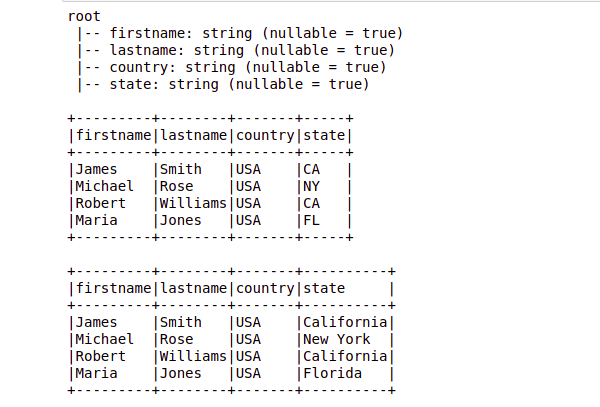

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType

spark =  SparkSession.builder.appName('spark_app').getOrCreate()

states = {"NY":"New York", "CA":"California", "FL":"Florida"}
broadcastStates = spark.sparkContext.broadcast(states)

data = [("James","Smith","USA","CA"),
    ("Michael","Rose","USA","NY"),
    ("Robert","Williams","USA","CA"),
    ("Maria","Jones","USA","FL")
  ]

columns = ["firstname","lastname","country","state"]
df = spark.createDataFrame(data = data, schema = columns)
df.printSchema()
df.show(truncate=False)

def state_convert(code):
    return broadcastStates.value[code]

# user defined function
udf_state_convert = udf(lambda x: state_convert(x), StringType())

result = df.withColumn('state', udf_state_convert(col('state')))
result.show(truncate=False)

22/10/18 17:38:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
root
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)

+---------+--------+-------+-----+
|firstname|lastname|country|state|
+---------+--------+-------+-----+
|James    |Smith   |USA    |CA   |
|Michael  |Rose    |USA    |NY   |
|Robert   |Williams|USA    |CA   |
|Maria    |Jones   |USA    |FL   |
+---------+--------+-------+-----+



+---------+--------+-------+----------+
|firstname|lastname|country|state     |
+---------+--------+-------+----------+
|James    |Smith   |USA    |California|
|Michael  |Rose    |USA    |New York  |
|Robert   |Williams|USA    |California|
|Maria    |Jones   |USA    |Florida   |
+---------+--------+-------+----------+

